In [32]:
import numpy as np
import pandas as pd
import scipy.stats as scs
from numpy import mean, std
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import ShuffleSplit, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from collections import defaultdict

In [5]:
covid = pd.read_csv('../data/full_feature_covid.csv')
covid = covid.set_index('GEOID')

#clean up nans
covid = covid.fillna(0)

#break out categorical data
covid = pd.get_dummies(covid, columns=['DominantReligion','Region'])

#save georegion for later
geocols = ['County', 'State','Geographical_Point','Geographical_Point','Target_PctChg']
geo = covid[geocols]

#Drop categorical columns that won't help with our model and one column form each dummy set
cols = ['County', 'State','Geographical_Point','Region_West','DominantReligion_Other']
covid = covid.drop(cols, axis = 1)

#normalize data
covid['Target_PctChg'] = covid['Target_PctChg']/10
covid['Unempl_Rate'] = covid['Unempl_Rate']/100
covid['Median_HHI'] = covid['Median_HHI']/covid['Median_HHI'].sum()
covid['DensPerSqMile'] = covid['DensPerSqMile']/covid['DensPerSqMile'].sum()
covid['Avg_HH_Size'] = covid['Avg_HH_Size']/10
covid['Avg_Fam_Size'] = covid['Avg_Fam_Size']/10
covid.mean(axis=0)

covid.head()

X = covid.copy()
y = X.pop('Target_PctChg')

X_train, X_test, y_train, y_test = train_test_split(X.astype(float), y, test_size=0.2, random_state=1) 




In [6]:
#mean is the baseline for all models
mean_arr = np.zeros(y_test.shape)
mean_arr[mean_arr==0] = y.mean()
y_hat_mean = mean_arr

In [13]:
#linear regression
summ = summary_model(X_train,y_train)

#linear regression
ols = linear_model.LinearRegression()
model = ols.fit(X_train, y_train)
y_hat_ols = model.predict(X_test)
mse_ols = mean_squared_error(y_hat_ols, y_test)
print(mse_ols)

#crossvalidation
print(kfcv(X_train, y_train, linear_model.LinearRegression()))

0.0124175005575578
(0.013931423412426008, 0.010420538899705747, 0.017394189897688903)


Train_error: 0.014203196916702314
Test_error: 0.014129369932542477
<ipython-input-12-51080efa1868>:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
Train_error: 0.01348773313700269
Test_error: 0.014477334859977061
<ipython-input-12-51080efa1868>:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
Train_error: 0.010862067460129018
Test_error: 0.013416434184858838
<ipython-input-12-51080efa1868>:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
Train_error: 0.009861024042769987
Test_error: 0.024147827666112627
<ipython-input-12-51080efa1868>:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the fi

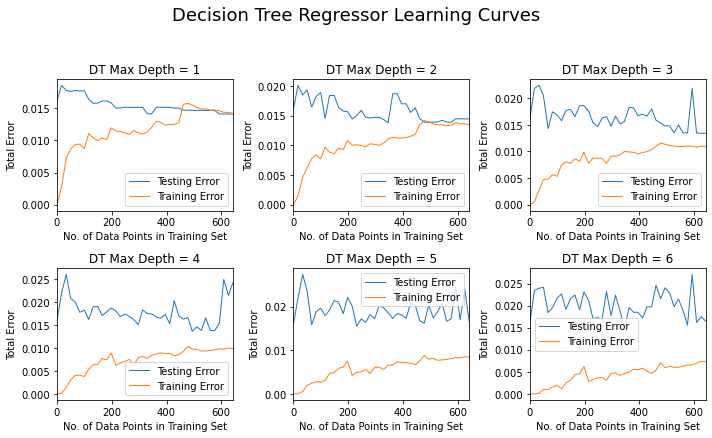

In [21]:
#decision tree tuning
learning_curves(X_train, y_train, X_test, y_test);

In [20]:
#decision tree
dt_6 = DecisionTreeRegressor(max_depth=6)
dt_6.fit(X_train, y_train)
y_hat_dt_6 = dt_6.predict(X_test)
mse_dt_6 = mean_squared_error(y_hat_dt_6, y_test)

dt_3 = DecisionTreeRegressor(max_depth=3)
dt_3.fit(X_train, y_train)
y_hat_dt_3 = dt_3.predict(X_test)
mse_dt_3 = mean_squared_error(y_hat_dt_3, y_test)

print(mse_dt_6, mse_dt_3)
print(kfcv(X_train, y_train, DecisionTreeRegressor(max_depth=3)))

0.016495644797801624 0.01341643418485884
(0.019733680948336087, 0.014278453470957497, 0.024141963881679836)


In [15]:
#random Forest - base model
model = RandomForestRegressor(n_estimators=100, bootstrap=True, max_features='sqrt')
model.fit(X_train, y_train)
# Actual class predictions
rf_predictions_base = model.predict(X_test)
mse_rf_base = mean_squared_error(rf_predictions_base, y_test)

print(mse_rf_base)
print(kfcv(X_train, y_train, RandomForestRegressor(n_estimators=100, bootstrap=True, max_features='sqrt')))

0.013371049726903474
(0.014577956316492547, 0.011007557060377834, 0.022627611242736594)


In [16]:
print(gridsearch(X, y))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


In [17]:
#random forest - best model based on 
best_model = RandomForestRegressor(n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=10, bootstrap=True)
best_model.fit(X_train, y_train)
# Actual class predictions
rf_predictions_best = best_model.predict(X_test)
mse_rf_best = mean_squared_error(rf_predictions_best, y_test)
mse_rf_best
#{'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}

0.012731841750482203

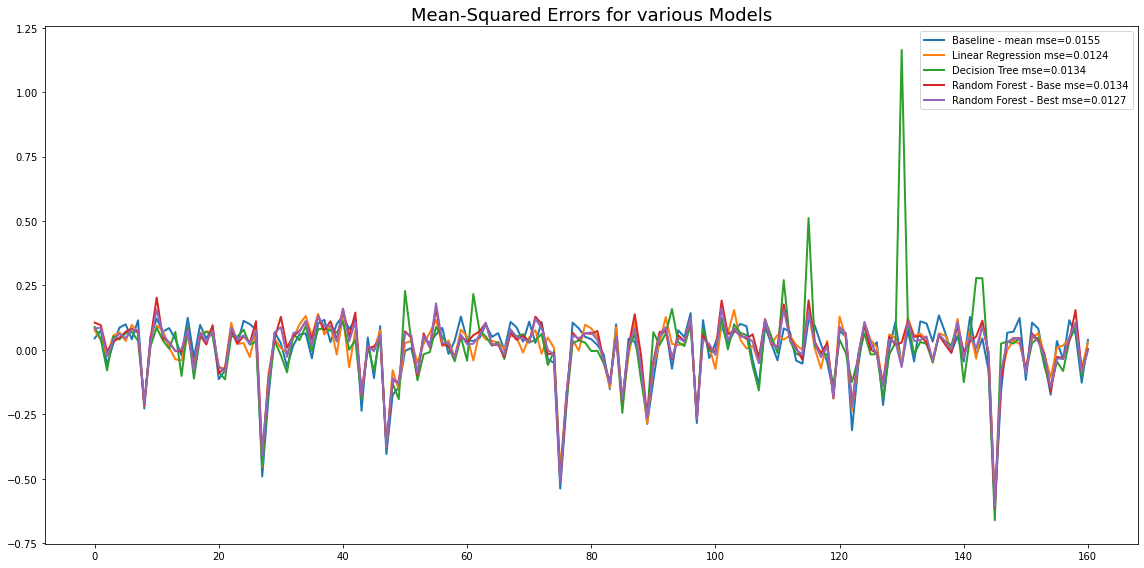

In [23]:
#graph errors
datapoints = list(range(len(y_test)))

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(datapoints, y_hat_mean - y_test, lw = 2, label='Baseline - mean mse={:.4f}'.format(0.01553))
ax.plot(datapoints, y_hat_ols - y_test, lw=2, label='Linear Regression mse={:.4f}'.format(mean_squared_error(y_hat_ols,y_test)))
ax.plot(datapoints, y_hat_dt - y_test, lw=2, label='Decision Tree mse={:.4f}'.format(mean_squared_error(y_hat_dt_3, y_test)))
ax.plot(datapoints, rf_predictions_base - y_test, lw=2, label='Random Forest - Base mse={:.4f}'.format(mean_squared_error(rf_predictions_base, y_test)))
ax.plot(datapoints, rf_predictions_best - y_test, lw=2, label='Random Forest - Best mse={:.4f}'.format(mean_squared_error(rf_predictions_best, y_test)))

ax.set_title('Mean-Squared Errors for various Models', fontsize=18)
plt.legend(loc='best')

fig.tight_layout()
plt.savefig('../img/mse.png', dpi=100)


In [24]:
#Predict the entire data set
all_predictions = best_model.predict(X)
predicted_rate_of_change = np.array(all_predictions*10)
#predicted_rate_of_change

In [26]:
#Plot geographic info
geo.info()
geo['NewPrediction'] = predicted_rate_of_change
geo.describe()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 803 entries, 10001 to 9015
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   County              803 non-null    object 
 1   State               803 non-null    object 
 2   Geographical_Point  803 non-null    object 
 3   Geographical_Point  803 non-null    object 
 4   Target_PctChg       803 non-null    float64
 5   NewPrediction       803 non-null    float64
dtypes: float64(2), object(4)
memory usage: 43.9+ KB


,Target_PctChg,NewPrediction
count,803.000000,803.000000
mean,0.427263,0.450369
std,1.246977,0.527317
min,-1.000000,-0.575807
25%,-0.374599,0.047847
50%,0.032717,0.373047
75%,0.876443,0.782279
max,12.678571,2.848150


<AxesSubplot:>

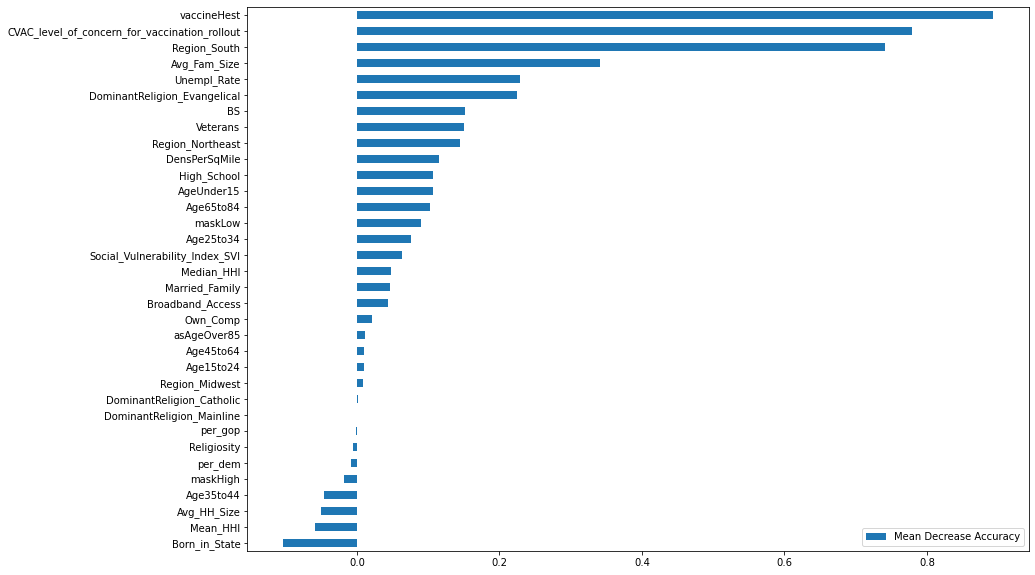

In [27]:
#Feature importance based on random forest
# manual shuffle 
rf = RandomForestRegressor()
scores = defaultdict(list)

names = X.columns
 
rf = RandomForestRegressor()
scores = defaultdict(list)

# crossvalidate the scores on a number of 
# different random splits of the data
splitter = ShuffleSplit(100, test_size=.3)

for train_idx, test_idx in splitter.split(X, y):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    rf.fit(X_train, y_train)
    acc = r2_score(y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(y_test, rf.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)

score_series = pd.DataFrame(scores).mean()
scores = pd.DataFrame({'Mean Decrease Accuracy' : score_series})
scores.sort_values(by='Mean Decrease Accuracy').plot(kind='barh', figsize = (14,10))


In [ ]:
#based on feature importance, compute correlations of significant predictors
for col in cols:
    print('{} {}'.format(col,compute_correlation(covid[col],y)))
    
for col in cols:
    print('{} {}'.format(col,spearmanr(covid[col],y))

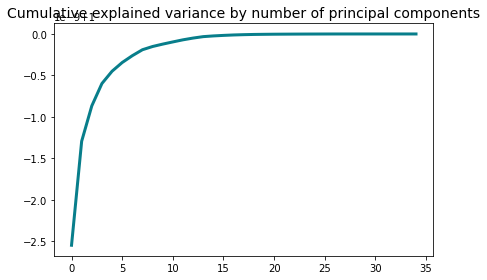

In [38]:
from sklearn.decomposition import PCA
pca = PCA().fit(covid)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=14)
plt.tight_layout()
plt.show()


In [41]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(len(covid.columns))],
    index=covid.columns
)

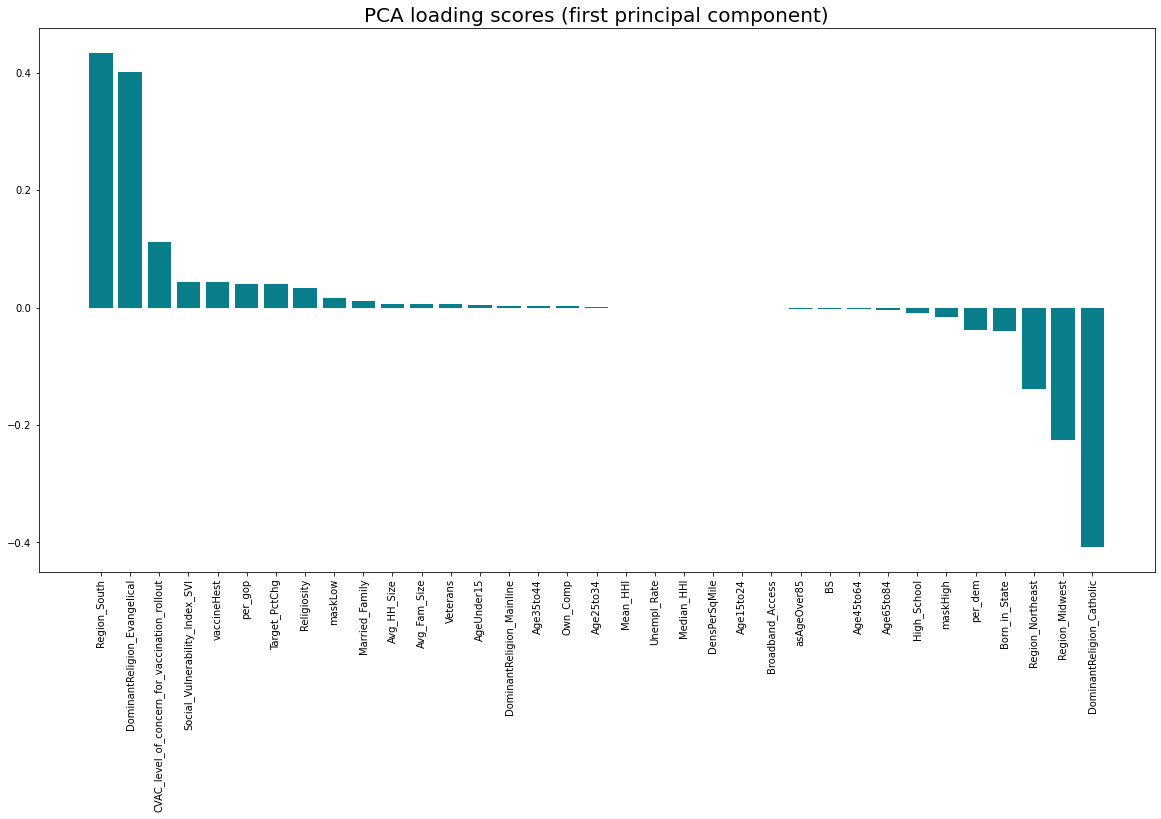

In [42]:


pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.figure(figsize=(20,10))
plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')

plt.savefig('PCA.png', dpi=100)
plt.show()

In [50]:
#run models using only columns in PCA analyis
cols = ['Region_South','DominantReligion_Evangelical','CVAC_level_of_concern_for_vaccination_rollout','DominantReligion_Catholic','Region_Midwest','Region_Northeast']
pca = covid[cols]

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca, y, test_size=0.2, random_state=1) 

pca_rf = RandomForestRegressor(n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=10, bootstrap=True)
pca_rf.fit(X_train_pca, y_train_pca)
pca_rf_predictions = pca_rf.predict(X_test_pca)
mse_pca = mean_squared_error(pca_rf_predictions, y_test_pca)

pca_dt_3 = DecisionTreeRegressor(max_depth=3)
pca_dt_3.fit(X_train_pca, y_train_pca)
y_hat_pca_dt_3 = pca_dt_3.predict(X_test_pca)
mse_pca_dt_3 = mean_squared_error(y_hat_pca_dt_3, y_test_pca)

In [51]:
print(mse_pca)
print(mse_pca_dt_3)

0.014464924269599692
0.01358868098783525


In [12]:
#linear regression OLS
def summary_model(X, y, label='scatter'):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    summary = model.summary()
    return summary

def plot_model(X, y, label='Residual Plot'):
    model = sm.OLS(y, X).fit()
    student_resids = model.outlier_test()['student_resid']
    y_hats = model.predict(X)

    plt.scatter(y_hats, student_resids, alpha = .35, label=label)
    plt.legend()
    plt.show()

def learning_curves(X_train, y_train, X_test, y_test):
    
    fig = plt.figure(figsize=(10,8))
    # Generate 40 evenly spaced numbers (rounded to nearest integer) over a specified interval 1 to 354
    datapoints = np.rint(np.linspace(1, len(X_train), 40)).astype(int)
    #initialise array of shape (40,)
    train_err = np.zeros(len(datapoints))
    test_err = np.zeros(len(datapoints))
 
    # Create 6 different models based on max_depth
    for k, depth in enumerate(range(1,7)):
        for i, s in enumerate(datapoints):
            reg = DecisionTreeRegressor(max_depth = depth) #increasing depth
            # Iteratively increase training set size
            reg.fit(X_train[:s], y_train[:s])
            # MSE for training and test sets of increasing size
            train_err[i] = mean_squared_error(y_train[:s], reg.predict(X_train[:s]))
            test_err[i] = mean_squared_error(y_test, reg.predict(X_test))

        print('Train_error: {}'.format(train_err[-1]))
        print('Test_error: {}'.format(test_err[-1]))
 
        # Subplot learning curves
        sub = fig.add_subplot(3, 3, k+1)
        sub.plot(datapoints, test_err, lw = 1, label = 'Testing Error')
        sub.plot(datapoints, train_err, lw = 1, label = 'Training Error')
        sub.legend()
        sub.set_title('DT Max Depth = %s'%(depth))
        sub.set_xlabel('No. of Data Points in Training Set')
        sub.set_ylabel('Total Error')
        sub.set_xlim([0, len(X_train)])
        
        fig.suptitle('Decision Tree Regressor Learning Curves', fontsize=18, y=1.03)
        fig.tight_layout()
        fig.show()

def bootstrap_confidence_interval(data, function, alpha=0.05, n_bootstraps=1000):
    '''return a the confidence interval for a function of data using bootstrapping'''
    medians = []
    for _ in range(n_bootstraps):
        bootstrap_sample = np.random.choice(data, len(data))
        medians.append(function(bootstrap_sample))
    return (np.percentile(medians, 100*(alpha/2.)),
            np.percentile(medians, 100*(1-alpha/2.))), medians

def gridsearch(x, y):
    # Number of trees in random forest
	n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
	# Number of features to consider at every split
	max_features = ['auto', 'sqrt']
	# Maximum number of levels in tree
	max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
	max_depth.append(None)
	# Minimum number of samples required to split a node
	min_samples_split = [2, 5, 10]
	# Minimum number of samples required at each leaf node
	min_samples_leaf = [1, 2, 4]
	# Method of selecting samples for training each tree
	bootstrap = [True, False]
	# Create the random grid
	random_grid = {'n_estimators': n_estimators,
		'max_features': max_features,
		'max_depth': max_depth,
		'min_samples_split': min_samples_split,
		'min_samples_leaf': min_samples_leaf,
		'bootstrap': bootstrap}

	#print(random_grid)

	# Use the random grid to search for best hyperparameters
	# First create the base model to tune
	rf = RandomForestRegressor()
	# Random search of parameters, using 3 fold cross validation, 
	# search across 100 different combinations, and use all available cores
	rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
	# Fit the random search model
	rf_random.fit(x, y)

	return rf_random.best_params_

def kfcv(X, y, mdl, num_splits=5):

    kf = KFold(n_splits=num_splits, shuffle=True)
    fold_scores = []

    for train, test in kf.split(X):
        model = mdl 
        model.fit(X.values[train], y.values[train])
        y_hat = model.predict(X.values[test])
        fold_scores.append(mean_squared_error(y_hat,y.values[test]))

    return np.mean(fold_scores), np.min(fold_scores), np.max(fold_scores)